In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [4]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [5]:
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist)

In [6]:
X, y = mnist["data"], mnist["target"]

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [10]:
some_digits = X[36000]
some_digits_image = some_digits.reshape(28,28)

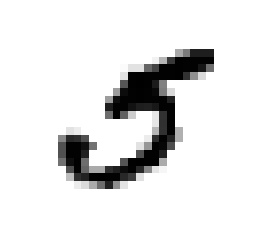

In [11]:
plt.imshow(some_digits_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [12]:
y[36000]

5

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [15]:
y_train_5 = (y_train == 5)
y_train_5

array([False, False, False, ..., False, False, False])

In [16]:
y_test_5 = (y_test == 5)
y_test_5

array([False, False, False, ..., False, False, False])

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
sgd_clf.predict([some_digits])

array([ True])

# Cross-Validation

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.96565
0.96515
0.96135


In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96565, 0.96515, 0.96135])

## Accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets.

In [22]:
from sklearn.base import BaseEstimator
import numpy as np

In [23]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")    # score

array([0.90705, 0.91055, 0.91135])

# Confusion Matrix

In [25]:
from sklearn.model_selection import cross_val_predict

In [26]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)      # predict
y_train_pred

array([False, False, False, ..., False, False, False])

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_train_5, y_train_pred)

array([[53961,   618],
       [ 1539,  3882]])

In [29]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

# Precision and Recall

In [30]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8626666666666667

In [31]:
recall_score(y_train_5, y_train_pred)

0.716104039845047

In [32]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7825824009676444

In [33]:
y_scores = sgd_clf.decision_function([some_digits])
y_scores

array([165673.12746382])

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [35]:
sgd_clf.predict([some_digits])

array([ True])

In [36]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### ==> Rasing the threshold decreases recall. 

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [38]:
y_scores

array([ -190013.85044917,  -143190.28416276,  -385663.43079533, ...,
        -577856.379801  , -1082040.43046791,  -526835.92696293])

## Compute precision and recall for all possible thresholds.

In [39]:
from sklearn.metrics import precision_recall_curve

In [40]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [41]:
precisions.shape

(59512,)

In [42]:
recalls.shape

(59512,)

In [43]:
thresholds.shape

(59511,)

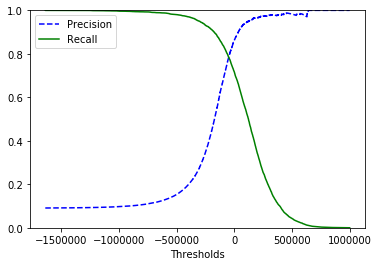

In [44]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Thresholds")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

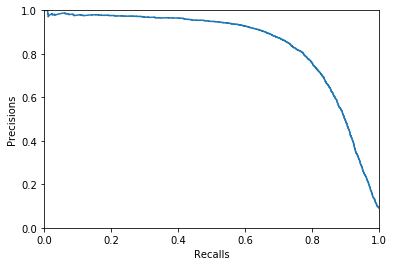

In [45]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("Recalls")
    plt.ylabel("Precisions")
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [46]:
y_train_pred_90 = (y_scores > 70000)
y_train_pred_90

array([False, False, False, ..., False, False, False])

In [47]:
precision_score(y_train_5, y_train_pred_90)

0.9301587301587302

In [48]:
recall_score(y_train_5, y_train_pred_90)

0.5945397528131341

# The ROC Curve
The receiver operating characteristic.

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [50]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99105883, 0.99105883,
       1.        ])

In [51]:
tpr

array([0.00000000e+00, 1.84467810e-04, 1.08836008e-02, ...,
       9.99815532e-01, 1.00000000e+00, 1.00000000e+00])

In [52]:
thresholds

array([  999200.58252162,   999199.58252162,   640740.68471617, ...,
       -1637860.20789371, -1638147.02524105, -2961294.4040837 ])

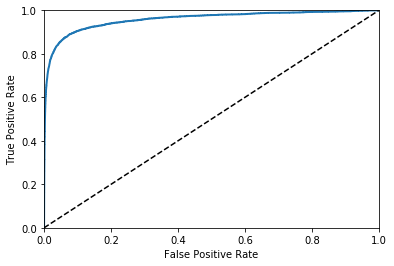

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

$ TPR=\frac{TP}{TP+FN} $

$ FPR=\frac{FP}{FP+TN} $

## Area Under the Curve (AUC)
A prefect classifier will have a ROC AUC equal to 1.

In [54]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9585146464936978

## RandomForest with AUC

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [56]:
y_probas_forest

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [57]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0., 0., 0., ..., 0., 0., 0.])

In [58]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

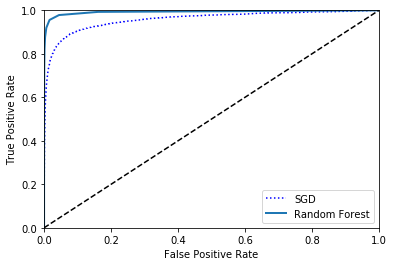

In [59]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [60]:
roc_auc_score(y_train_5, y_scores_forest)

0.9928450864920619

# Multiclass Classfication

In [61]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [62]:
sgd_clf.predict([some_digits])

array([5], dtype=int8)

In [63]:
some_digit_scores = sgd_clf.decision_function([some_digits])
some_digit_scores

array([[-226525.37922882, -435245.58453503, -248416.4341038 ,
        -282521.61662229, -349076.71989857,  165673.12746382,
        -853731.69189376, -210254.10950396, -581451.5607749 ,
        -719352.68863404]])

In [64]:
np.argmax(some_digit_scores)

5

In [65]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [66]:
sgd_clf.classes_[5]

5

### OvO strategy, based on a SGDClassifier

In [67]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digits])

array([5], dtype=int8)

In [68]:
len(ovo_clf.estimators_)

45

Random Forest classifiers can directly classify instances into multiple classed.

In [69]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digits])

array([5], dtype=int8)

In [70]:
forest_clf.predict_proba([some_digits])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

cross_val_score

In [71]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8519796 , 0.86779339, 0.8660299 ])

In [72]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.94046191, 0.94034702, 0.94049107])

In [73]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.91541692, 0.90464523, 0.9046357 ])

Scaling the inputs increases accuracy above 90%.

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90786843, 0.90774539, 0.91188678])

# Error Analysis

In [75]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [76]:
y_train_pred

array([8, 9, 4, ..., 2, 2, 4], dtype=int8)

In [77]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5750,    2,   22,    9,   11,   39,   42,    9,   36,    3],
       [   2, 6452,   52,   26,    6,   44,    7,   12,  128,   13],
       [  58,   38, 5335,   95,   78,   24,   90,   62,  163,   15],
       [  58,   35,  145, 5332,    3,  238,   37,   61,  126,   96],
       [  21,   26,   39,    7, 5339,   10,   52,   38,   89,  221],
       [  74,   43,   32,  176,   72, 4610,  109,   34,  176,   95],
       [  40,   21,   53,    2,   40,   82, 5630,    7,   43,    0],
       [  27,   17,   71,   27,   56,   11,    7, 5782,   19,  248],
       [  60,  155,   71,  159,   12,  155,   57,   22, 5004,  156],
       [  48,   36,   24,   94,  138,   38,    2,  186,   67, 5316]])

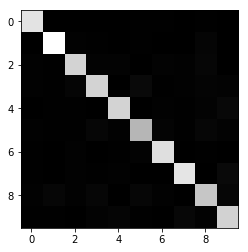

In [78]:
plt.imshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Compare error rate instead of absolute numbers of errors.
+ Rows represent actual classes;
+ Columns represent predicted classes.

In [79]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

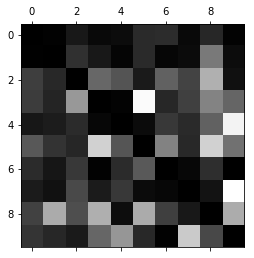

In [80]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [81]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

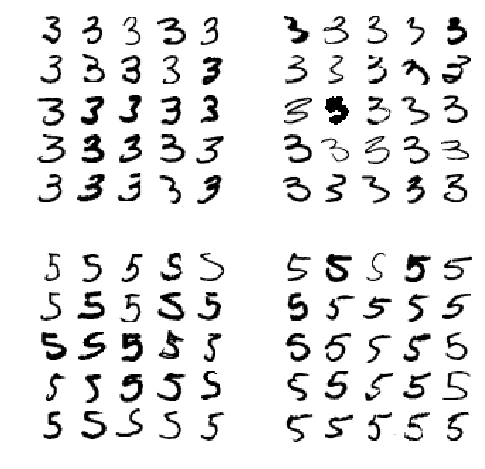

In [82]:
import matplotlib as mpl

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel Classification

In [83]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [84]:
# knn_clf.predict([some_digits])

In [92]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, 
               interpolation="nearest")
    plt.axis("off")

In [86]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
# f1_score(y_train, y_train_knn_pred, average="macro")

In [91]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

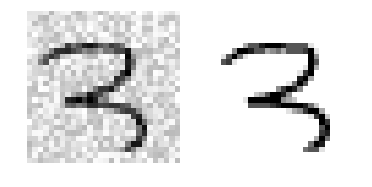

In [97]:
some_index = 5000
plt.subplot(121); plot_digit(X_train_mod[some_index])
plt.subplot(122); plot_digit(y_train_mod[some_index])

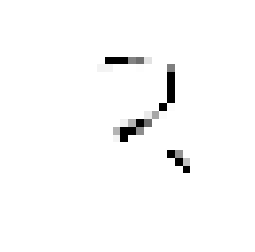

In [100]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod[some_index]])
plot_digit(clean_digit)